# DBSCAN (Density-based spatial clustering of applications with noise)

Given a set of points in some space, DBSCAN groups together points that are closely packed together (points with many **nearby neighbors**), marking as outliers points that lie in low-density regions(whose nearest neighbors are too far away).

For the purpose of DBSCAN clustering,points are classified as **core points**, (density-)reachable points and **outliers**, as follows:

- A point *p* is a core point if at least minPts points are within distance $\epsilon$($\epsilon$ is the maximum radius of the neighborhood from $p$) of it (including $p$). Those points are said to be **directly reachable** from $p$.
- A point $q$ is directly reachable from $p$ if point $q$ is within distance $\epsilon$ from point $p$ and $p$ must be a core point.
- A point $q$ is reachable from $p$ if there is a path  $p_1, ..., p_n$ with $p_1=p$ and $p_n=q$, where each $p_{i+1}$ is directly reachable from $p_i$ (all the points on the path must be core points, with possible exception of $q$).
- All points not reachable from any other points are outliers.

Now if $p$ is a core point, then it forms a cluster together with all points (core or non-core) that are reachable from it. Each cluster contains at least one core point; non-core points can be part of a cluster, but they form its "edge", since they cannot be used to reach more points.

Reachability is not a symmetric relation since, by definition, no point may be reachable from a non-core point, regardless of distance (so a non-core point may be reachable, but nothing can be reached from it). Therefore, a further notion of connectedness is needed to formally define the extent of the clusters found by DBSCAN. Two points p and q are density-connected if there is a point o such that both p and q are reachable from o. Density-connectedness is symmetric.

A cluster then satisfies two properties:

1. All points within the cluster are mutually density-connected.
2. If a point is density-reachable from any point of the cluster, it is part of the cluster as well.


## Advantages
1. It does not require one to specify the number of clusters in the data a priori, as opposed to [k-means](https://github.com/andersy005/machine-learning/blob/master/clustering/01-k-means.ipynb).
2. It can find arbitrary shaped clusters. It can even find a cluster completely surrounded (but not connected) to a different cluster. Due to the MinPts parameter, the so-called single-link effect(different clusters being connected by a thin line of points) is reduced 
3. It has a notion of noise, and is robust to **outliers**.
4. It requires just two parameters and is mostly insensitive to the ordering of the points in the dataset. (However, points sitting on the edge of two different clusters might swap cluster membership if the ordering of the points is changed, and the cluster assignment is unique only up to isomorphism.
5. It is designed for use with databases that can accelerate region queries
6. The parameters minPts and $\epsilon$ can be set by a domain expert, if the data is well understood.


## Disadvantages
1. It is not entirely deterministic: border points that are reachable from more than one cluster can be part of either cluster, depending on the order the data are processed.

2. The quality of DBSCAN depends on the [**distance measure**](https://goo.gl/s92Lts) used. The most common distance metric is **Euclidean distance**. 
3. It cannot cluster data sets well with large differences in densities, since the $minPts-\epsilon$ combination cannot then be chosen appropriately for all clusters.
4. If the data and scale are not well understood, choosing a meaningful distance threshold $\epsilon$ can be difficult.



Memory consumption for large sample sizes

DBSCAN sklearn implementation is by default not memory efficient because it constructs a full pairwise similarity matrix in the case where kd-trees or ball-trees cannot be used (e.g. with sparse matrices). This matrix will consume $n^2$ floats. A couple of mechanisms for getting around this are:

- A sparse radius neighborhood graph (where missing entries are presumed to be out of eps) can be precomputed in a memory-efficient way and dbscan can be run over this with `metric='precomputed'`.
- The dataset can be compressed, either by removing exact duplicates if these occur in your data, or by using [BIRCH](https://en.wikipedia.org/wiki/BIRCH). Then you only have a relatively small number of representatives for a large number of points. You can then provide a `sample_weight` when fitting DBSCAN.



## DBSCAN on the handwritten digits data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
np.random.seed(42)

In [2]:
# Load the data
digits = load_digits()

#Standardize the dataset along any axis
#Center to the mean and component wise scale to unit variance.
data = scale(digits.data)

In [3]:
n_samples, n_features = data.shape
print(n_samples, n_features)

1797 64


In [4]:
sample_size = 300
labels = digits.target
n_digits = len(np.unique(labels))
n_digits

10

In [5]:
# Reduce the data using PCA
reduced_data = PCA(n_components=2).fit_transform(data)

In [6]:
# Compute DBSCAN
db = DBSCAN(eps=0.4, min_samples=14).fit(reduced_data)

In [7]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)

In [8]:
core_samples_mask[db.core_sample_indices_] = True

In [9]:
labels_pred = db.labels_

In [10]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels_pred)) - (1 if -1 in labels else 0)


In [11]:
homo = metrics.homogeneity_score(labels, db.labels_)
compl = metrics.completeness_score(labels, db.labels_)
v_means = metrics.v_measure_score(labels, db.labels_)
ARI = metrics.adjusted_rand_score(labels, db.labels_)
AMI = metrics.adjusted_mutual_info_score(labels, db.labels_)
silhouette = metrics.silhouette_score(reduced_data, db.labels_)

In [12]:
print('Estimated number of clusters: %d' % n_clusters_)
print(55 * '_')
print('homo\tcompl\tv-meas\tARI\tAMI\tsilhouette')
print(55 * '_')
print('%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f' % (homo, compl, v_means, ARI, AMI,
                                              silhouette))

Estimated number of clusters: 10
_______________________________________________________
homo	compl	v-meas	ARI	AMI	silhouette
_______________________________________________________
0.243	0.416	0.307	0.129	0.235	-0.228


### Plotting

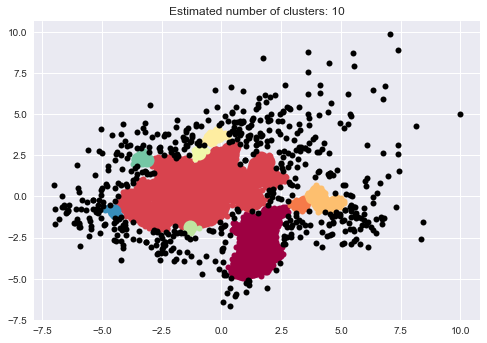

In [13]:
# Black removed and is used for noise instead.
unique_labels = set(labels_pred)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels_pred == k)

    xy = reduced_data[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = reduced_data[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## References
- [Demo of DBSCAN clustering algorithm](http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py)
- [DBSCAN-wikipedia](https://en.wikipedia.org/wiki/DBSCAN)
- [sklearn docs- DBSCAN](http://scikit-learn.org/stable/modules/clustering.html#dbscan)

In [14]:
%load_ext version_information
%version_information numpy, sklearn, matplotlib

Software versions
Python 3.6.3 64bit [MSC v.1900 64 bit (AMD64)]
IPython 6.2.1
OS Windows 10 10.0.16299 SP0
numpy 1.13.3
sklearn 0.19.1
matplotlib 2.1.1
Wed Jan 17 14:42:47 2018 Central Standard Time